# Evaluación del caso “Sitnikov modificado con control de periodicidad”

Este notebook estudia una variante del problema de Sitnikov: dos estrellas de masas similares orbitan en el plano XY y un tercer cuerpo ligero se mueve a lo largo del eje Z. Ajustamos las masas mediante el pipeline híbrido (GA + refinamiento continuo) para buscar órbitas casi periódicas y con menor sensibilidad caótica medida mediante el exponente de Lyapunov.

> **Interpretación**
> - La penalización `periodicity_weight` fuerza que el estado final se acerque al inicial; un valor pequeño del fitness implica trayectoria casi repetitiva.
> - Comparar λ del centro del rango de masas contra el λ optimizado permite medir cuánto se estabiliza la dinámica vertical del tercer cuerpo.

## Preparación del entorno

Normalizamos la ruta raíz del proyecto y la insertamos en `sys.path` para que los imports funcionen sin importar desde qué carpeta se lance el notebook.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias y utilidades clave

Cargamos los componentes fundamentales del flujo:
- `Config` y utilidades de seeding para reproducibilidad.
- El `ContinuousOptimizationController`, visualizadores 2D/3D y el adaptador REBOUND base.
- `numpy` y `pathlib` para manejar resultados y artefactos en disco.


In [ ]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path

## Instrumentación de rendimiento

Activamos trazas de tiempo a nivel de bloque (`time_block`) y preparamos utilidades para recuperar los CSV agregados. Esto permite auditar el costo de cada fase del pipeline directamente desde el notebook.

In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Formato de logging para el notebook

Registramos un `logging.Handler` personalizado que acumula los mensajes y los muestra con `display(Markdown(...))`, manteniendo limpio el flujo de salida mientras corren las generaciones del GA.


In [4]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="DEBUG")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)


## Configuración del escenario “Sitnikov modificado”

Definimos el diccionario `case` con:
- Integración a largo plazo (`t_end_long = 6000`, `dt = 0.08`) usando `whfast`.
- Condiciones iniciales simétricas para el binario y un tercer cuerpo con desplazamiento ligero en Y/Z.
- Límites estrechos para las masas estelares y un rango reducido para el tercer cuerpo.
- Penalización de periodicidad (`periodicity_weight = 0.08`) y presupuesto de evaluación amplio para que el GA explore soluciones estables.

In [5]:
case = {
    # Integración
    "t_end_short": 600.0,
    "t_end_long": 6000.0,
    "dt": 0.08,
    "integrator": "whfast",

    # Condiciones iniciales (Sitnikov modificado)
    "r0": (
        (-1.2, 0.0, 0.0),
        (1.2, 0.0, 0.0),
        (0.0, 0.1, 0.0),
    ),
    "v0": (
        (0.0, -0.32, 0.0),
        (0.0, 0.32, 0.0),
        (0.0, 0.55, 0.0),
    ),

    # Parámetros físicos
    "mass_bounds": (
        (0.48, 0.55),    # estrella 1
        (0.48, 0.55),    # estrella 2
        (5e-3, 1.5e-2),  # tercer cuerpo, rango acotado
    ),
    "G": 1.0,
    "periodicity_weight": 0.08,   # penaliza la deriva entre estado inicial y final

    # GA / búsqueda continua
    "pop_size": 150,
    "n_gen_step": 1,
    "crossover": 0.85,
    "mutation": 0.06,
    "elitism": 1,
    "seed": 1234,

    # Control de ejecución
    "max_epochs": 12,
    "top_k_long": 10,
    "stagnation_window": 6,
    "stagnation_tol": 5e-4,
    "local_radius": 0.05,
    "radius_decay": 0.85,
    "time_budget_s": 1800.0,
    "eval_budget": 60000,

    # Artefactos / salida
    "artifacts_dir": "artifacts/sitnikov_opt",
    "save_plots": True,
    "headless": False,
}

In [6]:
from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

cfg = Config(**case)
logger = setup_logger()

## Adaptador especializado de REBOUND

Subclasamos `ReboundSim` para imponer la restricción de Sitnikov: tras cada paso, fijamos `x = vx = 0` del tercer cuerpo de modo que la partícula se mantenga sobre el eje Z. Mediante un monkeypatch temporal logramos que el `FitnessEvaluator` utilice este integrador personalizado durante todo el experimento.


In [7]:
import rebound

class SitnikovReboundSim(ReboundSim):
    def setup_simulation(self, *args, **kwargs):
        sim = super().setup_simulation(*args, **kwargs)

        def clamp(_sim_ptr=None):
            if len(sim.particles) > 2:
                particle = sim.particles[2]
                particle.x = 0.0
                particle.vx = 0.0

        sim.post_timestep_modifications = clamp
        return sim

# Monkeypatch para que FitnessEvaluator use el adaptador sitnikov
from two_body.simulation import rebound_adapter
rebound_adapter.ReboundSim = SitnikovReboundSim

c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.48, 0.55), (0.48, 0.55), (0.005, 0.015)) 12 60000


## Ejecución del controlador híbrido

Creamos la configuración, el `logger` y el `ContinuousOptimizationController`. Usamos `time_block("notebook_run")` para medir la ejecución completa (GA + refinamiento), registramos los eventos relevantes y recopilamos el mejor individuo encontrado.


In [9]:
with time_block("notebook_run", extra={"source": "Caso01.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-10-29 00:08:17,249] INFO - Starting optimization | pop=150 | dims=3 | time_budget=1800.0s | eval_budget=60000
[2025-10-29 00:08:35,320] INFO - Epoch 0 | new global best (short) lambda=0.000552 | fitness=-299.518313 | penalty=3743.972014 | masses=(0.547512, 0.481192, 0.011766)


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\pymoo\termination\ftol.py:27: RuntimeWarning: invalid value encountered in scalar subtract
  return max(0, prev - current)


[2025-10-29 00:08:47,604] INFO - Epoch 0 complete | lambda_short=0.000552 | fitness_short=-299.518313 | lambda_best=0.000552 | fitness_best=-299.518313 | evals short/long=150/10 | total evals=160 | radius=0.0500
[2025-10-29 00:09:06,916] INFO - Epoch 1 | new global best (short) lambda=0.000553 | fitness=-298.433754 | penalty=3730.415018 | masses=(0.548833, 0.482667, 0.005301)
[2025-10-29 00:09:19,012] INFO - Epoch 1 complete | lambda_short=0.000553 | fitness_short=-298.433754 | lambda_best=0.000553 | fitness_best=-298.433754 | evals short/long=150/10 | total evals=320 | radius=0.0500
[2025-10-29 00:09:48,400] INFO - Epoch 2 complete | lambda_short=0.000557 | fitness_short=-399.688160 | lambda_best=0.000553 | fitness_best=-298.433754 | evals short/long=150/10 | total evals=480 | radius=0.0500
[2025-10-29 00:10:16,413] INFO - Epoch 3 complete | lambda_short=0.000560 | fitness_short=-531.284020 | lambda_best=0.000553 | fitness_best=-298.433754 | evals short/long=150/10 | total evals=640 |

## Métricas de referencia y resultado óptimo

Calculamos el fitness del centro de los intervalos (`center`) como línea base y lo comparamos con la solución óptima (`results["best"]`). También recuperamos `metrics` para inspeccionar la evolución de λ por época y cualquier otra estadística almacenada por el controlador.

In [10]:
metrics = controller.metrics
results

{'status': 'completed',
 'best': {'masses': [0.55, 0.48, 0.005],
  'lambda': 0.000548244429386521,
  'fitness': -249.85749952249697,
  'm1': 0.55,
  'm2': 0.48,
  'm3': 0.005},
 'evals': 1920,
 'epochs': 12}

## Seguimiento de λ y reconstrucción de trayectorias

Visualizamos:
- La secuencia `metrics.best_lambda_per_epoch` y, opcionalmente, un suavizado para detectar tendencias.
- Las trayectorias 3D integradas con las masas óptimas (`viz_3d.animate_3d`) y cualquier proyección 2D rápida (`viz_planar.quick_view`) para confirmar la estabilidad obtenida.


In [11]:
from two_body.logic.fitness import FitnessEvaluator
from two_body.core.cache import HierarchicalCache
from two_body.simulation.rebound_adapter import ReboundSim

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)
baseline = evaluator.evaluate_batch([center], horizon="long")[0]
best_fit = results["best"]["fitness"]

print(f"λ inicial = {-baseline:.6f}, λ óptimo = {-best_fit:.6f}")

λ inicial = inf, λ óptimo = 249.857500


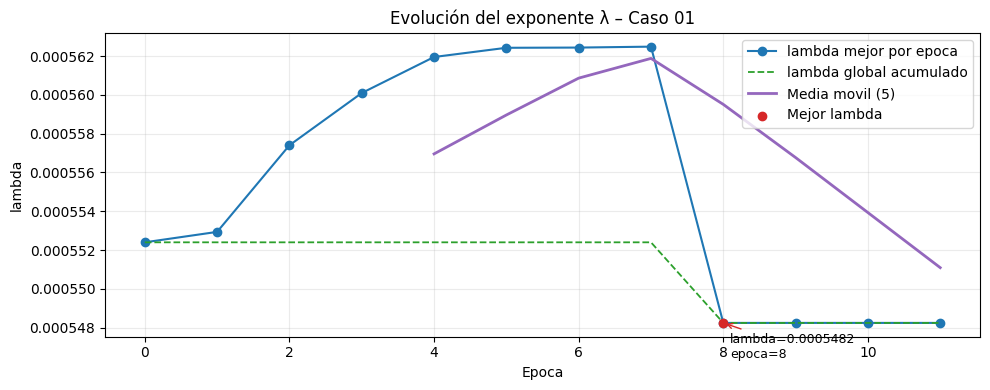

In [12]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 01",
    moving_average_window=5,   # opcional
)

In [13]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]

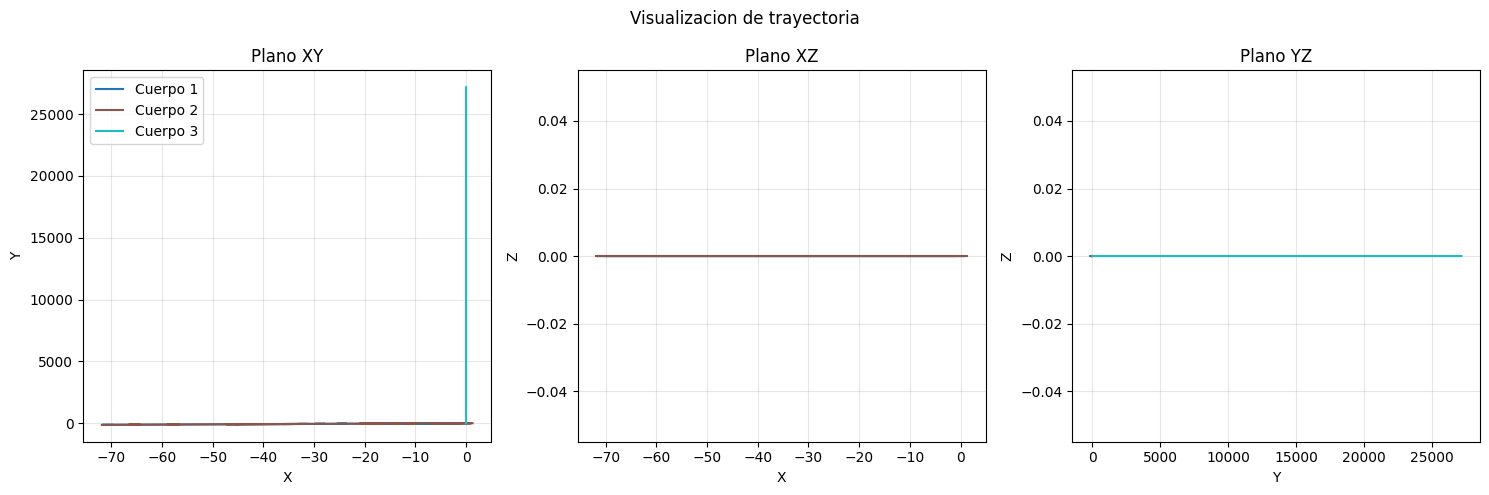

In [14]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks) 

In [15]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 1024  # MB

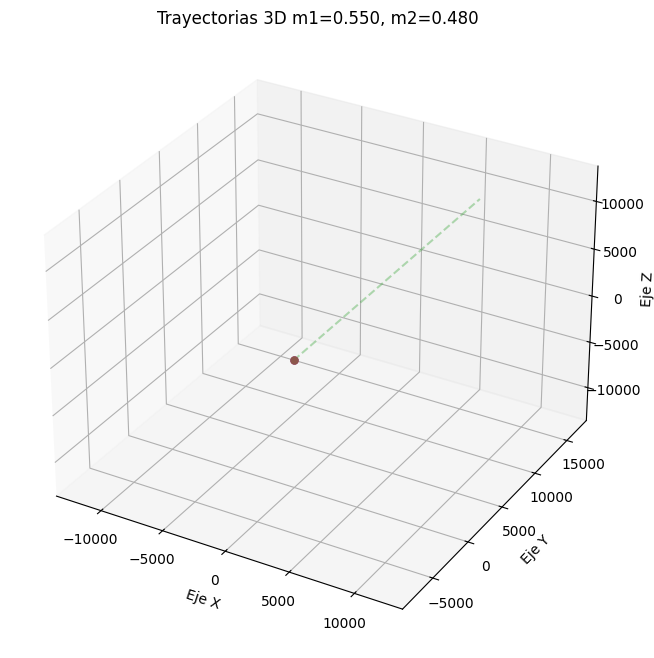

In [17]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Configuramos un `FFMpegWriter`, nos aseguramos de que el directorio `artifacts/caso02` exista y persistimos los MP4 de la trayectoria final y de la comparación de masas. Ajusta `fps`, `bitrate` o el preset de ffmpeg si necesitas reducir el tiempo de render.


In [18]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(fps=1000 // 50, bitrate=2400)   # fps = 1000/interval_ms
output_path = Path("artifacts/caso02")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\simulation.py:259: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


ValueError: Axis limits cannot be NaN or Inf

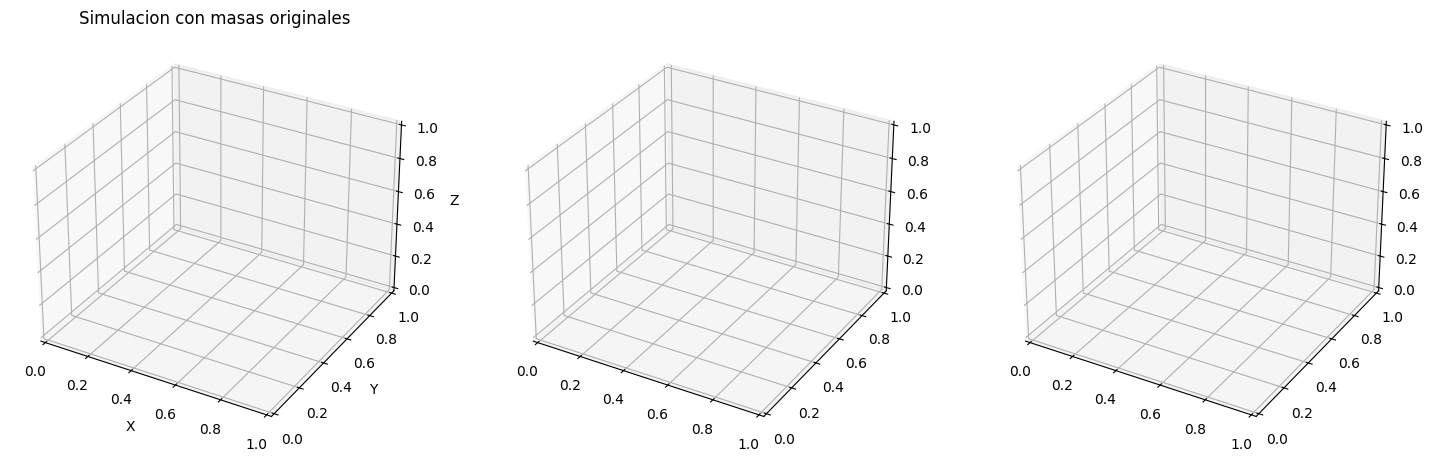

In [19]:
anim_mass = viz_3d.plot_mass_comparison(
    original_masses=center,
    optimized_masses=best_masses,
    body_labels=[f"Cuerpo {i+1}" for i in range(len(best_masses))],
    title="Comparativa de masas (Caso 01)",
)
#HTML(anim_mass.to_jshtml())  

In [ ]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos

Leemos el CSV más reciente generado por la instrumentación, mostramos las primeras filas y podemos agregar estadísticas por sección para identificar cuellos de botella del pipeline en este escenario.


In [22]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

'Usando CSV: C:\\Users\\emicr\\Documents\\CODIGOS_FUENTES\\TrabajoTerminal\\collision_of_two_bodies\\two_body\\data\\timings\\timings_410c61c6-2269-43f3-b56e-21b33937096b_20251029_060809.csv'

,run_id,epoch,batch_id,individual_id,section,start_ns,end_ns,duration_us,extra
0,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070622800,23344070691700,68,"{'step': 0, 'dt': 0.1, 't_target': 0.1}"
1,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070727400,23344070752600,25,"{'step': 1, 'dt': 0.1, 't_target': 0.2}"
2,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070767900,23344070800400,32,"{'step': 2, 'dt': 0.1, 't_target': 0.300000000..."
3,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070812700,23344070835600,22,"{'step': 3, 'dt': 0.1, 't_target': 0.4}"
4,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070843800,23344070868000,24,"{'step': 4, 'dt': 0.1, 't_target': 0.5}"
5,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070876300,23344070907100,30,"{'step': 5, 'dt': 0.1, 't_target': 0.600000000..."
6,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344070914800,23344071017100,102,"{'step': 6, 'dt': 0.1, 't_target': 0.700000000..."
7,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344071024300,23344072015300,991,"{'step': 7, 'dt': 0.1, 't_target': 0.8}"
8,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344072024300,23344072438300,414,"{'step': 8, 'dt': 0.1, 't_target': 0.9}"
9,410c61c6-2269-43f3-b56e-21b33937096b,-1,-1,-1,simulation_step,23344072446700,23344072541000,94,"{'step': 9, 'dt': 0.1, 't_target': 1.0}"


,count,mean,sum
section,,,
batch_eval,81,2.563310e+07,2076281003
fitness_eval,4481,4.633180e+05,2076127746
lyapunov_compute,3833,5.414733e+05,2075466980
notebook_run,1,2.074689e+09,2074688739
simulation_step,10396975,1.846217e+02,1919506905
ga_main,40,2.688555e+04,1075422
crossover,607,4.878023e+02,296096
selection_tournament,607,1.949127e+02,118312
mutation,607,1.720148e+02,104413


In [23]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"


Ejecutando: c:\Users\emicr\anaconda3\envs\grav2body\python.exe scripts/plot_timings.py --run-id 410c61c6-2269-43f3-b56e-21b33937096b --top-n 5
Graficas guardadas en C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies\two_body\reports




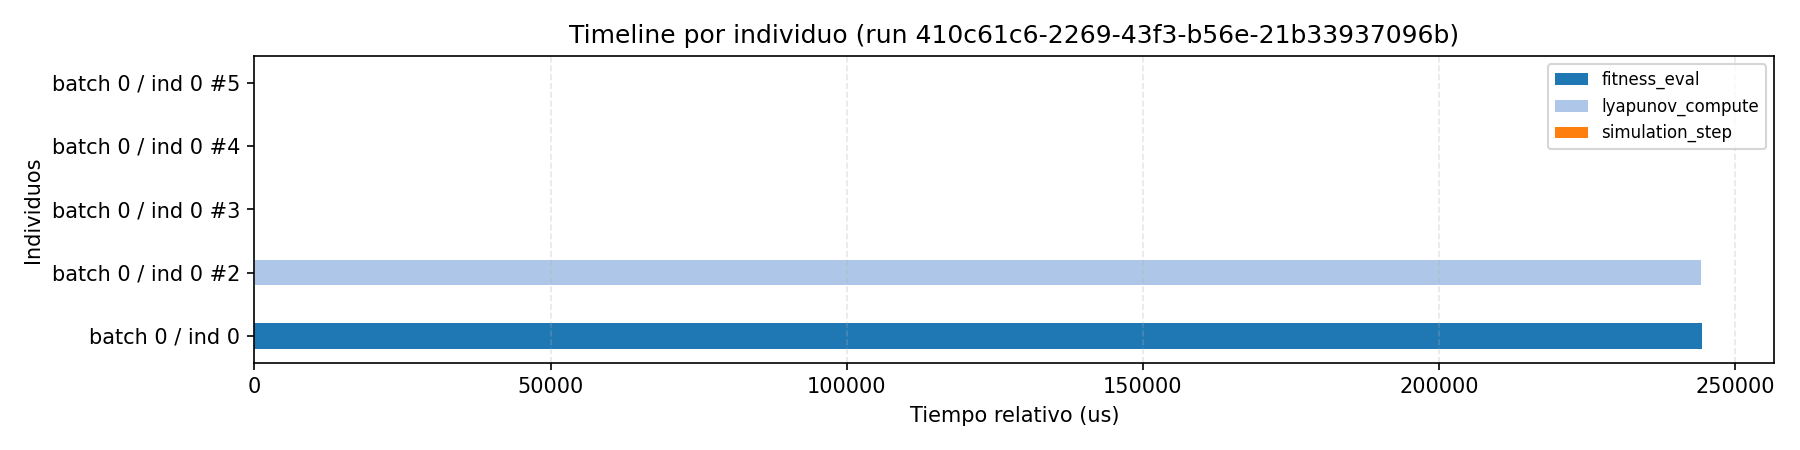

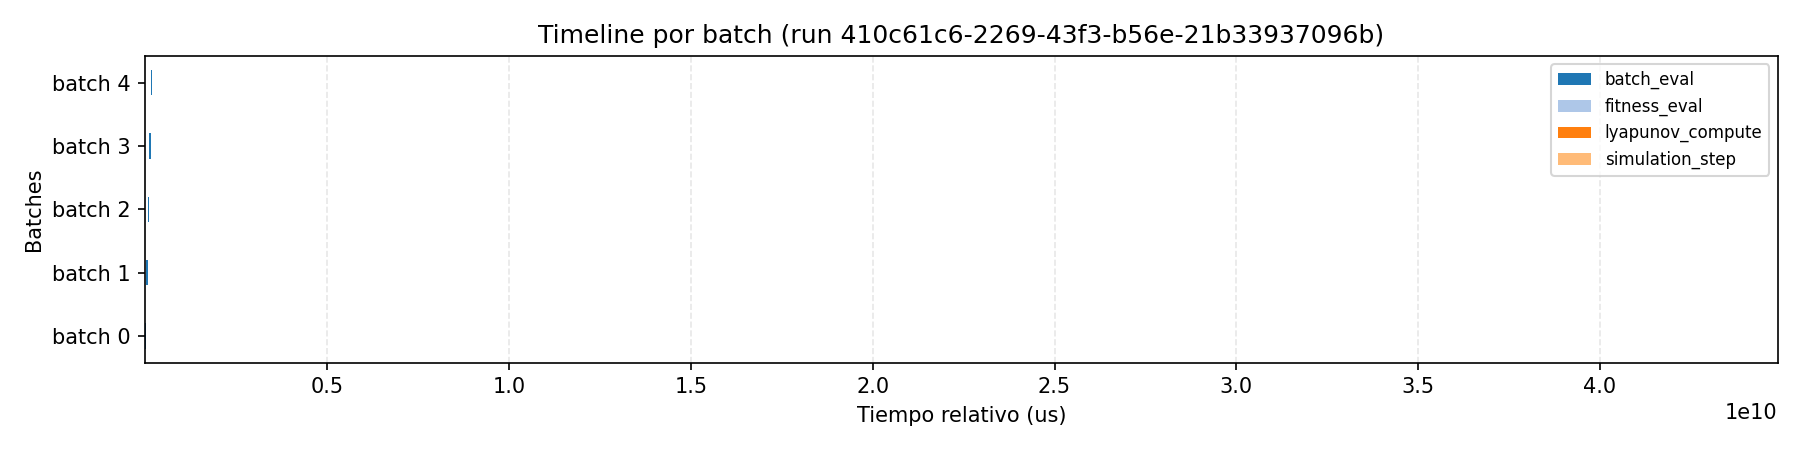

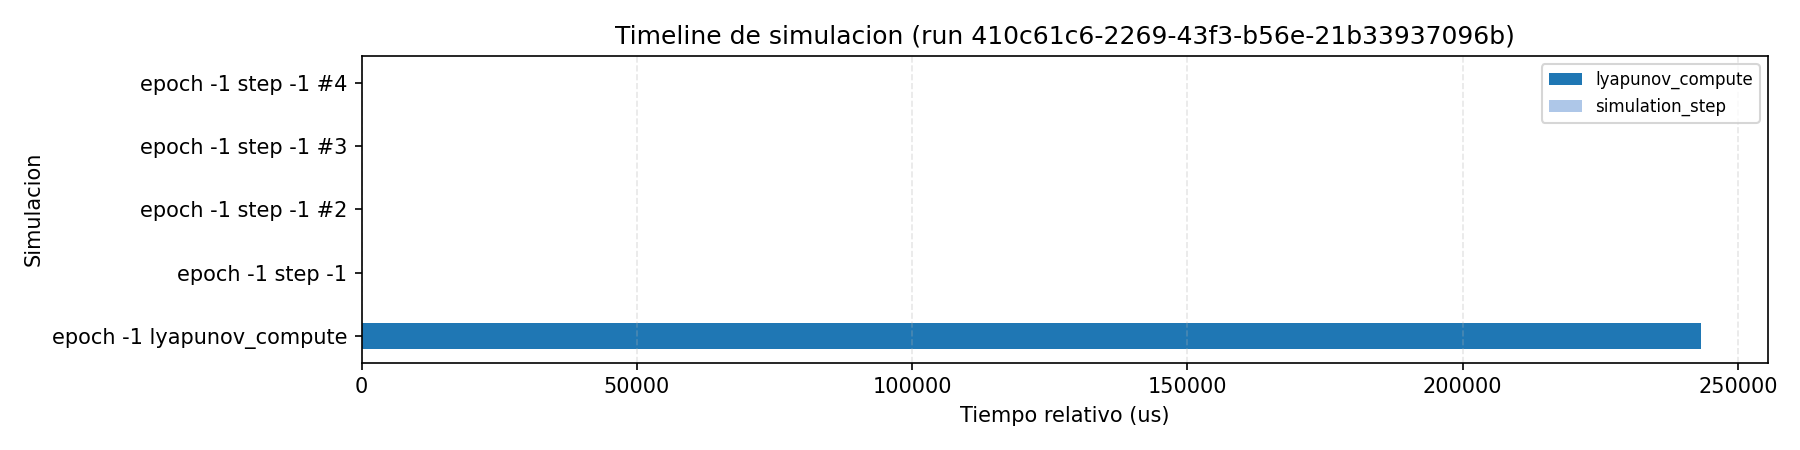

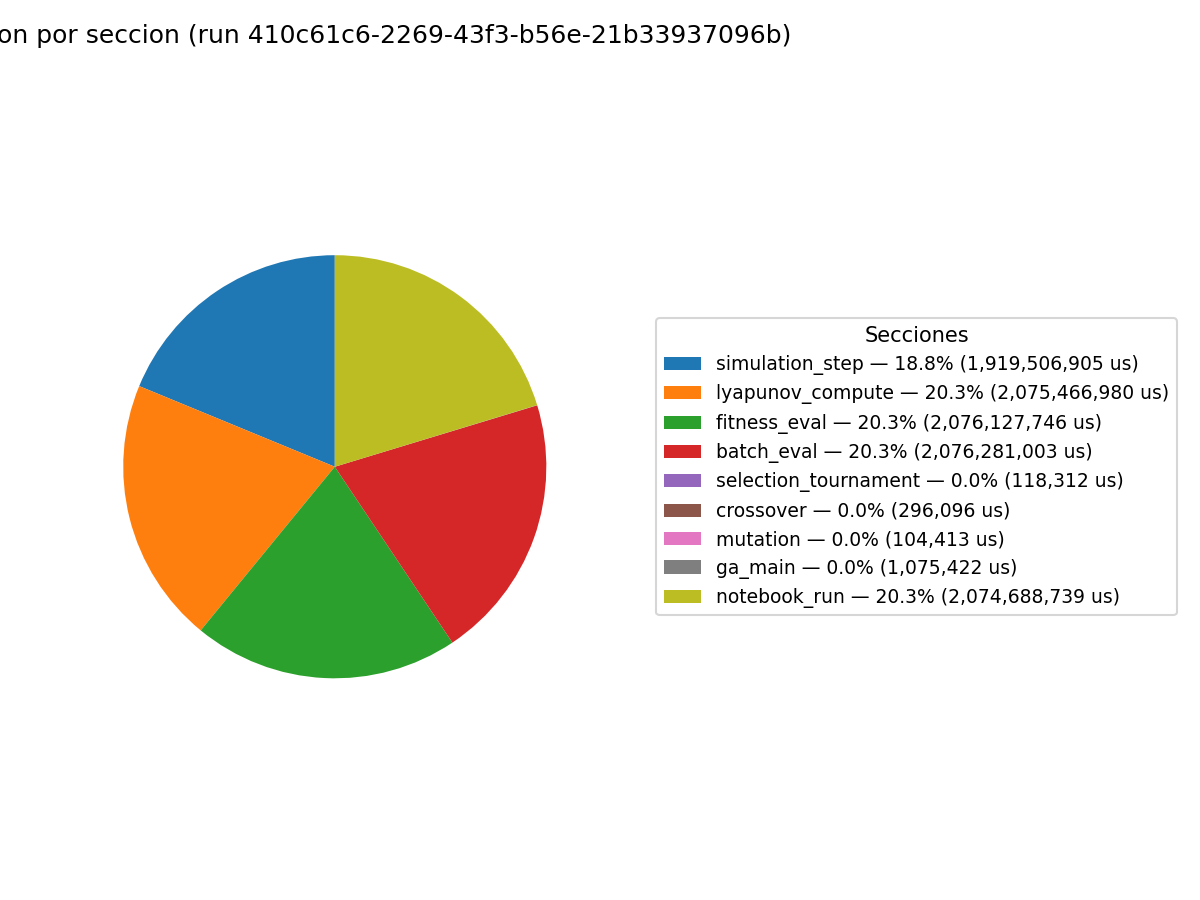

In [24]:
display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)